# Color thresholding semantic segmentation

Whole-slide images often contain artifacts like marker or acellular regions that
need to be avoided during analysis. In this example we show how HistomicsTK can
be used to develop saliency detection algorithms that segment the slide at low
magnification to generate a map to guide higher magnification analyses. Here we
show how how colorspace analysis can detect various elements such as inking
or blood, as well as dense cellular regions, to improve the quality of
subsequent image analysis tasks.

This uses a thresholding and stain unmixing based pipeline to detect
highly-cellular regions in a slide. The `run()` method of the
`CDT_single_tissue_piece()` class has the key steps of the pipeline.

Additional functionality includes contour extraction to get the final segmentation boundaries and to visualize them in DSA using one's preferred styles.

**Here are some sample results:**

![saliency_results](https://user-images.githubusercontent.com/22067552/80079317-1bcaa580-851e-11ea-9353-a435a2afc6eb.jpg)

**Where to look?**

```
   |_ histomicstk/
     |_saliency/
        |_cellularity_detection_thresholding.py 
        |_tests/
           |_test_saliency.py
```

In [1]:
import tempfile
import girder_client
import numpy as np
from pandas import read_csv
from histomicstk.annotations_and_masks.annotation_and_mask_utils import (
    delete_annotations_in_slide)
from histomicstk.saliency.cellularity_detection_thresholding import (
    Cellularity_detector_thresholding)

import matplotlib.pylab as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

## Prepwork

In [2]:
APIURL = 'http://candygram.neurology.emory.edu:8080/api/v1/'
SAMPLE_SLIDE_ID = "5d8c296cbd4404c6b1fa5572"

gc = girder_client.GirderClient(apiUrl=APIURL)
gc.authenticate(apiKey='kri19nTIGOkWH01TbzRqfohaaDWb6kPecRqGmemb')

# This is where the run logs will be saved
logging_savepath = tempfile.mkdtemp()

# read GT codes dataframe
GTcodes = read_csv('../../histomicstk/saliency/tests/saliency_GTcodes.csv')

In [3]:
# deleting existing annotations in target slide (if any)
delete_annotations_in_slide(gc, SAMPLE_SLIDE_ID)

### Let's explore the GTcodes dataframe

In [4]:
GTcodes

,group,overlay_order,GT_code,is_roi,is_background_class,color,comments
0,outside_tissue,-1,255,0,0,"rgb(40,40,40)",NaN
1,roi,0,254,0,0,"rgb(0,0,0)",NaN
2,not_specified,0,253,0,1,"rgb(255,50,255)",NaN
3,blue_sharpie,1,6,0,0,"rgb(0,224,255)",NaN
4,blood,2,7,0,0,"rgb(255,255,0)",NaN
5,whitespace,3,8,0,0,"rgb(70,70,70)",NaN
6,maybe_cellular,4,9,0,0,"rgb(145,109,189)",NaN
7,top_cellular,5,10,0,0,"rgb(50,250,20)",NaN


## Initialize the cellularity detector

### Explore the docs

Get some idea about the implementation details and default behavior. 

In [5]:
print(Cellularity_detector_thresholding.__doc__)

Detect cellular regions in a slide using thresholding.

    This uses a thresholding and stain unmixing based pipeline
    to detect highly-cellular regions in a slide. The run()
    method of the CDT_single_tissue_piece() class has the key
    steps of the pipeline. In summary, here are the steps
    involved...

    1. Detect tissue from background using the RGB slide
    thumbnail. Each "tissue piece" is analysed independently
    from here onwards. The tissue_detection modeule is used
    for this step. A high sensitivity, low specificity setting
    is used here.

    2. Fetch the RGB image of tissue at target magnification. A
    low magnification (default is 3.0) is used and is sufficient.

    3. The image is converted to HSI and LAB spaces. Thresholding
    is performed to detect various non-salient components that
    often throw-off the color normalization and deconvolution
    algorithms. Thresholding includes both minimum and maximum
    values. The user can set whichever 

The only required arguments to initialize are `gc`, `slide_id`, and `GTcodes`.
Everything else is optional and assigned defaults, but you may want to read up on
what each argument does to adjust to your specific needs. The default behavior
is defined at the beginning of the `__init__()` method.

In [6]:
print(Cellularity_detector_thresholding.__init__.__doc__)

Init Cellularity_Detector_Superpixels object.

        Arguments:
        -----------
        gc : object
            girder client object

        slide_id : str
            girder ID of slide

        GTcodes : pandas Dataframe
            the ground truth codes and information dataframe.
            This is a dataframe that is indexed by the annotation group name
            and has the following columns...

            group: str
                group name of annotation, eg. mostly_tumor
            overlay_order: int
                how early to place the annotation in the
                mask. Larger values means this annotation group is overlayed
                last and overwrites whatever overlaps it.
            GT_code: int
                desired ground truth code (in the mask).
                Pixels of this value belong to corresponding group (class)
            is_roi: bool
                whether this group encodes an ROI
            is_background_class: bool
          

In [7]:
# init cellularity detector
cdt = Cellularity_detector_thresholding(
    gc, slide_id=SAMPLE_SLIDE_ID, GTcodes=GTcodes,
    verbose=2, monitorPrefix='test',
    logging_savepath=logging_savepath)

Saving logs to: /tmp/tmpclyolr1y/2019-10-27_17-51.log


## Set the color normalization values (optional)

By default, color normalization is performed using the macenko method and standardizing to
a hematoxylin and eosin standard from the target image
TCGA-A2-A3XS-DX1_xmin21421_ymin37486 from Amgad et al, 2019.

If you don't like this behavior, and would prefer to use your own target image or a
different color normalization method, use the set_color_normalization_method() below.

In [8]:
print(cdt.set_color_normalization_target.__doc__)

Set color normalization values to use from target image.

        Arguments:
        -----------
        ref_image_path : str
            path to target (reference) image

        color_normalization_method : str
            color normalization method to use. Currently, only
            'reinhard' and 'macenko_pca' are accepted.

        


## Run the detector

In [9]:
tissue_pieces = cdt.run()

test: set_slide_info_and_get_tissue_mask()
test: Tissue piece 1 of 1
test: Tissue piece 1 of 1: set_tissue_rgb()
test: Tissue piece 1 of 1: initialize_labeled_mask()
test: Tissue piece 1 of 1: assign_components_by_thresholding()
test: Tissue piece 1 of 1: -- get HSI and LAB images ...
test: Tissue piece 1 of 1: -- thresholding blue_sharpie ...
test: Tissue piece 1 of 1: -- thresholding blood ...
test: Tissue piece 1 of 1: -- thresholding whitespace ...
test: Tissue piece 1 of 1: color_normalize_unspecified_components()
test: Tissue piece 1 of 1: -- macenko normalization ...
test: Tissue piece 1 of 1: find_potentially_cellular_regions()
test: Tissue piece 1 of 1: find_top_cellular_regions()
test: Tissue piece 1 of 1: visualize_results()


## Check the results

The resultant list of objects correspond to the results for each "tissue piece" detected in the slide. You may explore various attributes like the offset coordinates and labeled mask.

In [10]:
print(
    'Tissue piece 0: ',
    'xmin', tissue_pieces[0].xmin,
    'xmax', tissue_pieces[0].xmax,
    'ymin', tissue_pieces[0].ymin,
    'ymax', tissue_pieces[0].ymax,
)

Tissue piece 0:  xmin 30455 xmax 113472 ymin 5403 ymax 67297


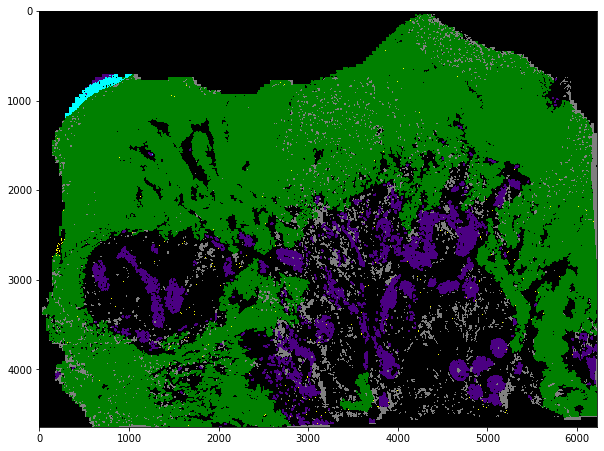

In [11]:
# color map
tmp = tissue_pieces[0].labeled.copy()
tmp[0, :256] = np.arange(256)
vals = ['black'] * 256
vals[6] = 'cyan'  # sharpie / ink
vals[7] = 'yellow'  # blood
vals[8] = 'grey'  # whitespace
vals[9] = 'indigo'  # maybe cellular
vals[10] = 'green'  # salient / top cellular
cMap = ListedColormap(vals)

plt.figure(figsize=(10,10))
plt.imshow(tmp, cmap=cMap)
plt.show()

## Check the visualization on HistomicsUI

Now you may go to the slide on Digital Slide Archive and check the posted annotations.